

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Imports


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Another classifier option
from xgboost import XGBClassifier

# For dealing with arff
import arff 


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# hierarquical
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.metrics import (h_fbeta_score,
                                                         h_precision_score, 
                                                         h_recall_score)

# creating hierarchy
from networkx import DiGraph
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm_notebook


In [2]:
TESTING = False
BASE_MODEL = DecisionTreeClassifier
RANDOM_STATE = 42
N_SIMUL = 100



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Helper functions


The following function was original found in the sklearn-hierarcical-classification libray; 
Unfortunately, due to a bug, it can't compile properly - we therefore include it here as taken from the source code.

In [3]:
from contextlib import contextmanager

import numpy as np
from networkx import all_pairs_shortest_path_length, relabel_nodes
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn_hierarchical_classification.constants import ROOT

@contextmanager
def multi_labeled(y_true, y_pred, graph):
    """
    Helper context manager for using the hierarchical evaluation metrics
    defined in this model.
    Briefly, the evaluation metrics expect data in a binarized multi-label format,
    the same as returned when using scikit-learn's MultiLabelBinarizer.
    This method therefore encapsulate the boilerplate required to fit such a
    label transformation on the data we wish to evaluate (y_true, y_pred) as well as
    applying it to the class hierarchy itself (graph), by relabeling the nodes.
    See the examples/classify_digits.py file for example usage.
    Parameters
    ----------
    y_true : array-like, shape = [n_samples, 1].
        ground truth targets
    y_pred : array-like, shape = [n_samples, 1].
        predicted targets
    graph : the class hierarchy graph, given as a `networkx.DiGraph` instance
    Returns
    -------
    y_true_ : array-like, shape = [n_samples, n_classes].
        ground truth targets, transformed to a binary multi-label matrix format.
    y_pred_ : array-like, shape = [n_samples, n_classes].
        predicted targets, transformed to a binary multi-label matrix format.
    graph_ : the class hierarchy graph, given as a `networkx.DiGraph` instance,
        transformed to use the (integer) IDs fitted by the multi label binarizer.
    """
    mlb = MultiLabelBinarizer()
    all_classes = [
        node
        for node in graph.nodes
        if node != ROOT
    ]
    # Nb. we pass a (singleton) list-within-a-list as fit() expects an iterable of iterables
    mlb.fit([all_classes])

    node_label_mapping = {
        old_label: new_label
        for new_label, old_label in enumerate(list(mlb.classes_))
    }

    yield (
        mlb.transform(y_true),
        mlb.transform(y_pred),
        relabel_nodes(graph, node_label_mapping),
)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Create experiment

In [4]:
df = pd.read_csv("data/instruments.csv")
df["class"] = df["class"].str.replace("-", "")

encoding = LabelEncoder()
last_classes = df["class"].str.split(".").apply(lambda x: x[-1]).unique()
encoding.fit(last_classes)

if TESTING:
    df = df.sample(frac=0.1)
    N_SIMUL = 2
    
all_results = pd.DataFrame(columns=["h_fbeta", "h_precision", "h_recall", "model"])

In [5]:
options = [x.split(".")[1:] for x in df["class"].unique()]
mosquitos_hierarchy = defaultdict(set)

for class_ in options:
    for previous, current in zip([ROOT]+class_, class_):
        if current in last_classes:
            class_num = encoding.transform([current])[0]
            mosquitos_hierarchy[previous].add(f"{class_num}")
        else:
            mosquitos_hierarchy[previous].add(current)

for key in mosquitos_hierarchy.keys():
    mosquitos_hierarchy[key] = list(mosquitos_hierarchy[key])

mosquitos_hierarchy = dict(mosquitos_hierarchy)

pprint(mosquitos_hierarchy)

{-1: ['Aerophone'],
 'Aerophone': ['Wood', 'Brass'],
 'Brass': ['7', '8', '6', '3'],
 'Wood': ['2', '4', '0', '5', '1']}


![Hierarquia mosquitos](../images/mosquitos.png)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [6]:
def run_experiment(df, class_hierarchy, encoding, clf, random_state=RANDOM_STATE):
    X = df.drop(columns="class")
    y = encoding.transform(df["class"].str.split(".").apply(lambda x: x[-1]))
    y = y.astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=random_state,
                                                       stratify=y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    if TESTING:
        target_names = encoding.inverse_transform(np.sort(np.unique(y)).astype(int))
        print("Classification Report:\n", 
              classification_report(y_test, y_pred, target_names=target_names))
        
    print(y_train, y_pred)
    # Demonstrate using our hierarchical metrics module with MLB wrapper
    try:
        my_graph = clf.graph_
    except:
        my_graph = DiGraph(class_hierarchy)
        
    print(y_test)
    with multi_labeled(y_test, y_pred, my_graph) as (y_test_, y_pred_, graph_):
        results = {
            "h_fbeta": h_fbeta_score(y_test_, y_pred_, graph_),
            "h_precision": h_precision_score(y_test_, y_pred_, graph_),
            "h_recall": h_recall_score(y_test_, y_pred_, graph_),
        }
    return results

In [7]:
def print_results(results):
    for key, item in results.items():
        print(f"Result for {key}: {item}")

# A better way to evaluate

Let's actually use the hierarchical data

[Functional Annotation of Genes Using Hierarchical Text Categorization](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.5824&rep=rep1&type=pdf)

## Hierarchical Precision and Recall

![](hierarchical_metrics.png)

## Hierarchical F1 score

The common way of calculating F1 is:
![](f1_normal.png)

The proposed hierarchical version is:
![](f1_hierarchical.png)

With beta = 1, we give equal weights to both precision and recall



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Models

## Flat

In [8]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = BASE_MODEL(random_state=rdm_state)
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    
    all_results.loc[len(all_results), :] = list(results.values()) + ["flat"]

['6' '8' '8' ... '7' '1' '1'] ['5' '2' '7' ... '2' '0' '5']
['5' '2' '2' ... '2' '0' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '1' '2' ... '8' '5' '5'] ['7' '1' '0' ... '8' '1' '8']
['7' '1' '0' ... '8' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '4' ... '2' '7' '2'] ['8' '4' '8' ... '4' '2' '8']
['8' '4' '3' ... '4' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '0' '7' ... '8' '4' '3'] ['1' '8' '2' ... '8' '6' '0']
['1' '8' '2' ... '8' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '3' ... '1' '5' '4'] ['8' '1' '2' ... '6' '6' '8']
['8' '3' '2' ... '6' '6' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '7' ... '5' '8' '6'] ['0' '2' '4' ... '8' '8' '2']
['4' '7' '4' ... '8' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '8' '2' ... '0' '4' '0'] ['8' '6' '3' ... '1' '6' '6']
['0' '2' '1' ... '1' '6' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '8' ... '7' '1' '3'] ['2' '3' '1' ... '1' '4' '2']
['2' '3' '1' ... '7' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '5' ... '8' '5' '3'] ['2' '5' '8' ... '6' '1' '8']
['2' '5' '8' ... '5' '7' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '8' ... '0' '0' '6'] ['4' '3' '8' ... '0' '5' '8']
['4' '5' '8' ... '0' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '2' '8' ... '8' '1' '4'] ['7' '5' '1' ... '1' '6' '2']
['5' '5' '4' ... '2' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '4' ... '0' '3' '6'] ['2' '7' '0' ... '7' '2' '6']
['6' '5' '0' ... '2' '2' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '2' '8' ... '7' '1' '0'] ['8' '1' '2' ... '6' '6' '1']
['8' '7' '6' ... '6' '6' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '2' '1' ... '5' '7' '5'] ['5' '1' '4' ... '4' '0' '8']
['5' '4' '4' ... '4' '0' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '8' '5' ... '8' '8' '7'] ['5' '2' '0' ... '0' '6' '6']
['5' '2' '0' ... '0' '6' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '7' '6' ... '8' '8' '1'] ['5' '1' '7' ... '3' '8' '2']
['5' '1' '7' ... '3' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '7' '0' ... '8' '6' '6'] ['5' '8' '6' ... '2' '6' '0']
['5' '8' '6' ... '2' '6' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '5' ... '3' '5' '5'] ['2' '0' '8' ... '4' '5' '5']
['2' '3' '8' ... '5' '5' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '2' '6' ... '1' '0' '8'] ['7' '8' '2' ... '1' '3' '0']
['7' '8' '2' ... '1' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '1' '2' ... '5' '3' '8'] ['0' '2' '8' ... '3' '4' '2']
['0' '2' '8' ... '3' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '4' '6' ... '1' '1' '2'] ['3' '2' '4' ... '1' '1' '6']
['6' '2' '4' ... '1' '1' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '4' '4' ... '4' '6' '6'] ['2' '2' '3' ... '2' '7' '5']
['7' '2' '3' ... '2' '7' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '8' '6' ... '7' '8' '8'] ['0' '1' '6' ... '2' '5' '0']
['0' '1' '3' ... '7' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '2' ... '5' '8' '2'] ['1' '2' '6' ... '2' '6' '7']
['4' '2' '6' ... '1' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '3' '0' ... '8' '8' '1'] ['4' '5' '4' ... '2' '6' '1']
['4' '5' '1' ... '2' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '6' '7' ... '7' '5' '1'] ['5' '5' '3' ... '0' '3' '7']
['1' '5' '3' ... '0' '3' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '3' ... '7' '8' '1'] ['5' '2' '5' ... '8' '0' '2']
['1' '0' '5' ... '8' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '7' ... '5' '8' '0'] ['4' '0' '5' ... '3' '4' '8']
['1' '0' '5' ... '3' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '7' '8' ... '4' '4' '8'] ['0' '1' '0' ... '6' '1' '3']
['3' '1' '0' ... '6' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '5' ... '1' '2' '7'] ['2' '0' '6' ... '0' '3' '2']
['2' '0' '6' ... '6' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '4' '2' ... '8' '5' '5'] ['3' '0' '4' ... '5' '1' '8']
['3' '0' '4' ... '5' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '8' '6' ... '7' '5' '2'] ['5' '6' '1' ... '4' '5' '1']
['5' '6' '1' ... '4' '5' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '2' '1' ... '8' '5' '6'] ['6' '6' '7' ... '6' '0' '5']
['6' '6' '7' ... '6' '0' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '6' '8' ... '1' '2' '4'] ['7' '3' '1' ... '4' '8' '4']
['7' '1' '5' ... '4' '8' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '0' '2' ... '1' '5' '5'] ['0' '2' '8' ... '2' '5' '8']
['5' '2' '8' ... '7' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '6' '6' ... '2' '6' '5'] ['2' '0' '0' ... '5' '8' '1']
['2' '0' '6' ... '5' '8' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '6' '1' ... '4' '4' '5'] ['2' '2' '0' ... '1' '8' '8']
['0' '2' '0' ... '1' '8' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '8' ... '8' '2' '8'] ['5' '1' '0' ... '6' '2' '8']
['5' '1' '0' ... '7' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '5' ... '0' '4' '3'] ['7' '3' '7' ... '1' '6' '3']
['7' '3' '7' ... '1' '6' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '8' ... '3' '8' '8'] ['4' '5' '7' ... '3' '1' '6']
['4' '5' '7' ... '1' '1' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '7' '3' ... '1' '0' '2'] ['5' '0' '6' ... '1' '3' '1']
['5' '0' '6' ... '1' '3' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '2' '1' ... '6' '0' '0'] ['3' '0' '2' ... '5' '1' '6']
['5' '0' '2' ... '5' '1' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '7' ... '4' '8' '3'] ['1' '2' '1' ... '3' '2' '8']
['7' '2' '6' ... '3' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '8' ... '5' '0' '8'] ['1' '0' '4' ... '5' '2' '7']
['4' '0' '4' ... '3' '2' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '7' '2' ... '3' '6' '8'] ['6' '1' '6' ... '4' '8' '7']
['6' '1' '6' ... '4' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '1' '1' ... '8' '4' '4'] ['7' '8' '2' ... '8' '3' '4']
['2' '8' '2' ... '8' '3' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '7' ... '3' '4' '4'] ['8' '0' '8' ... '8' '7' '4']
['8' '0' '8' ... '8' '7' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '4' '7' ... '1' '4' '3'] ['0' '7' '2' ... '3' '0' '5']
['0' '7' '2' ... '3' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '1' ... '1' '3' '3'] ['2' '5' '0' ... '8' '8' '6']
['2' '5' '0' ... '8' '8' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '2' ... '4' '4' '8'] ['5' '5' '6' ... '3' '2' '3']
['5' '5' '6' ... '3' '2' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '0' '4' ... '4' '4' '4'] ['3' '2' '7' ... '7' '7' '1']
['3' '2' '8' ... '5' '5' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '0' ... '2' '2' '8'] ['4' '8' '1' ... '6' '2' '2']
['4' '8' '1' ... '6' '2' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '2' '2' ... '5' '2' '5'] ['5' '0' '1' ... '0' '8' '2']
['5' '0' '1' ... '0' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '0' ... '8' '8' '2'] ['5' '1' '1' ... '4' '0' '8']
['7' '1' '1' ... '1' '3' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '6' '8' ... '7' '1' '3'] ['5' '4' '5' ... '1' '5' '3']
['5' '4' '5' ... '3' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '1' '0' ... '6' '5' '2'] ['4' '0' '1' ... '4' '7' '8']
['4' '3' '1' ... '1' '7' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '4' ... '2' '6' '2'] ['5' '6' '5' ... '5' '2' '5']
['5' '6' '5' ... '5' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '1' '2' ... '6' '8' '3'] ['6' '7' '7' ... '0' '6' '8']
['6' '4' '6' ... '0' '6' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '1' ... '2' '6' '0'] ['3' '7' '4' ... '0' '2' '3']
['3' '7' '4' ... '0' '2' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '7' '8' ... '1' '6' '7'] ['6' '2' '5' ... '7' '1' '0']
['6' '2' '2' ... '7' '1' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '1' '8' ... '3' '6' '0'] ['2' '6' '0' ... '7' '5' '8']
['2' '6' '0' ... '4' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '0' ... '2' '0' '3'] ['2' '7' '6' ... '7' '2' '8']
['2' '5' '6' ... '6' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '6' '2' ... '6' '8' '4'] ['7' '2' '5' ... '6' '5' '3']
['5' '2' '5' ... '6' '5' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '2' ... '6' '5' '1'] ['0' '2' '5' ... '6' '3' '2']
['0' '2' '6' ... '6' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '8' '7' ... '6' '7' '3'] ['7' '1' '8' ... '5' '6' '2']
['7' '5' '8' ... '5' '6' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '2' ... '0' '2' '6'] ['1' '2' '7' ... '7' '3' '8']
['1' '2' '5' ... '7' '3' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '1' ... '5' '0' '8'] ['2' '8' '8' ... '8' '8' '6']
['2' '8' '8' ... '8' '8' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '0' '1' ... '6' '8' '2'] ['4' '8' '6' ... '2' '4' '8']
['4' '8' '6' ... '2' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '5' '0' ... '2' '5' '0'] ['0' '5' '6' ... '5' '8' '2']
['0' '5' '6' ... '5' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '8' '2' ... '2' '2' '2'] ['6' '0' '4' ... '1' '2' '2']
['3' '3' '4' ... '4' '2' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '5' '2' ... '8' '4' '7'] ['6' '3' '8' ... '5' '6' '1']
['6' '6' '8' ... '3' '6' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '8' '2' ... '7' '0' '2'] ['6' '0' '5' ... '7' '1' '8']
['4' '0' '5' ... '2' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '1' ... '1' '4' '6'] ['5' '5' '4' ... '2' '1' '3']
['5' '3' '4' ... '7' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '6' ... '2' '1' '7'] ['6' '5' '5' ... '6' '3' '7']
['6' '5' '5' ... '6' '3' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '8' '5' ... '8' '3' '8'] ['8' '7' '8' ... '8' '7' '6']
['8' '7' '8' ... '8' '4' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '6' ... '6' '8' '0'] ['7' '2' '1' ... '2' '4' '2']
['7' '2' '1' ... '1' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '1' ... '4' '7' '6'] ['8' '1' '1' ... '2' '7' '5']
['8' '3' '6' ... '2' '2' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '8' ... '1' '0' '8'] ['2' '3' '5' ... '7' '5' '6']
['2' '3' '1' ... '6' '5' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '7' '8' ... '1' '5' '1'] ['8' '6' '3' ... '5' '3' '0']
['3' '6' '3' ... '5' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '2' ... '3' '5' '8'] ['3' '1' '1' ... '0' '5' '0']
['3' '1' '1' ... '0' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '2' ... '1' '3' '3'] ['5' '2' '0' ... '8' '8' '2']
['5' '2' '0' ... '8' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '8' '6' ... '3' '5' '5'] ['6' '4' '1' ... '2' '5' '6']
['6' '6' '2' ... '2' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '5' '4' ... '2' '5' '4'] ['2' '2' '1' ... '5' '2' '2']
['2' '2' '1' ... '5' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '6' ... '8' '4' '6'] ['1' '2' '5' ... '2' '4' '5']
['7' '2' '0' ... '2' '3' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '3' '2' ... '4' '2' '3'] ['3' '8' '7' ... '0' '8' '7']
['3' '8' '6' ... '0' '8' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '4' '6' ... '5' '5' '1'] ['8' '1' '1' ... '3' '2' '8']
['8' '1' '1' ... '3' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '3' '5' ... '2' '0' '2'] ['3' '0' '5' ... '0' '0' '8']
['1' '0' '5' ... '2' '0' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '0' '3' ... '8' '1' '1'] ['7' '4' '6' ... '3' '2' '4']
['7' '4' '6' ... '0' '2' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '8' '8' ... '3' '5' '1'] ['1' '8' '2' ... '2' '4' '4']
['7' '8' '5' ... '2' '4' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '2' ... '1' '3' '1'] ['1' '8' '8' ... '0' '4' '3']
['4' '8' '8' ... '0' '4' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '5' '0' ... '5' '1' '2'] ['2' '2' '8' ... '6' '1' '8']
['2' '2' '3' ... '6' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '7' ... '5' '0' '7'] ['8' '5' '5' ... '5' '4' '2']
['8' '5' '1' ... '5' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '7' ... '0' '1' '1'] ['1' '5' '0' ... '3' '1' '4']
['2' '5' '0' ... '5' '1' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '4' ... '4' '8' '5'] ['1' '2' '1' ... '8' '1' '8']
['1' '7' '1' ... '8' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '4' '5' ... '3' '5' '3'] ['5' '1' '3' ... '5' '4' '1']
['5' '1' '0' ... '5' '4' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '5' '1' ... '2' '1' '8'] ['6' '5' '8' ... '0' '8' '0']
['6' '5' '8' ... '0' '8' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '5' ... '5' '8' '7'] ['1' '0' '6' ... '1' '0' '4']
['1' '0' '6' ... '1' '0' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '0' '0' ... '6' '5' '6'] ['5' '2' '3' ... '7' '1' '1']
['5' '2' '6' ... '7' '0' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '0' '3' ... '0' '1' '8'] ['7' '8' '0' ... '1' '3' '0']
['7' '8' '0' ... '1' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '3' '8' ... '1' '1' '2'] ['3' '5' '0' ... '1' '5' '4']
['6' '5' '0' ... '4' '5' '4']

CPU times: user 26.5 s, sys: 108 ms, total: 26.6 s
Wall time: 26.5 s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Top Down

### 1 multiclass classifier per Node

In [9]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = HierarchicalClassifier(base_estimator=BASE_MODEL(), 
                             class_hierarchy=mosquitos_hierarchy, 
                             prediction_depth="mlnp",
                             algorithm="lcpn",
                            )   
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    all_results.loc[len(all_results), :] = list(results.values()) + ["1 per node"]

['6' '8' '8' ... '7' '1' '1'] ['0' '2' '2' ... '2' '0' '3']
['5' '2' '2' ... '2' '0' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '1' '2' ... '8' '5' '5'] ['6' '1' '0' ... '8' '0' '8']
['7' '1' '0' ... '8' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '4' ... '2' '7' '2'] ['8' '4' '3' ... '4' '2' '8']
['8' '4' '3' ... '4' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '0' '7' ... '8' '4' '3'] ['1' '8' '2' ... '8' '5' '0']
['1' '8' '2' ... '8' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '3' ... '1' '5' '4'] ['8' '3' '2' ... '6' '3' '8']
['8' '3' '2' ... '6' '6' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '7' ... '5' '8' '6'] ['4' '7' '4' ... '8' '8' '1']
['4' '7' '4' ... '8' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '8' '2' ... '0' '4' '0'] ['0' '2' '1' ... '1' '6' '6']
['0' '2' '1' ... '1' '6' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '8' ... '7' '1' '3'] ['1' '5' '1' ... '5' '4' '2']
['2' '3' '1' ... '7' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '5' ... '8' '5' '3'] ['2' '5' '8' ... '5' '2' '8']
['2' '5' '8' ... '5' '7' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '8' ... '0' '0' '6'] ['4' '3' '8' ... '0' '7' '8']
['4' '5' '8' ... '0' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '2' '8' ... '8' '1' '4'] ['5' '6' '4' ... '2' '4' '5']
['5' '5' '4' ... '2' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '4' ... '0' '3' '6'] ['3' '7' '3' ... '7' '2' '7']
['6' '5' '0' ... '2' '2' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '2' '8' ... '7' '1' '0'] ['8' '7' '6' ... '6' '6' '1']
['8' '7' '6' ... '6' '6' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '2' '1' ... '5' '7' '5'] ['5' '1' '4' ... '4' '6' '8']
['5' '4' '4' ... '4' '0' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '8' '5' ... '8' '8' '7'] ['6' '2' '0' ... '0' '6' '6']
['5' '2' '0' ... '0' '6' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '7' '6' ... '8' '8' '1'] ['5' '1' '7' ... '3' '8' '4']
['5' '1' '7' ... '3' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '7' '0' ... '8' '6' '6'] ['5' '8' '6' ... '2' '8' '3']
['5' '8' '6' ... '2' '6' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '5' ... '3' '5' '5'] ['2' '3' '8' ... '1' '7' '3']
['2' '3' '8' ... '5' '5' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '2' '6' ... '1' '0' '8'] ['7' '8' '2' ... '1' '3' '0']
['7' '8' '2' ... '1' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '1' '2' ... '5' '3' '8'] ['0' '2' '8' ... '3' '4' '2']
['0' '2' '8' ... '3' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '4' '6' ... '1' '1' '2'] ['6' '2' '4' ... '1' '1' '6']
['6' '2' '4' ... '1' '1' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '4' '4' ... '4' '6' '6'] ['5' '2' '3' ... '2' '7' '0']
['7' '2' '3' ... '2' '7' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '8' '6' ... '7' '8' '8'] ['0' '1' '3' ... '7' '5' '0']
['0' '1' '3' ... '7' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '2' ... '5' '8' '2'] ['1' '2' '6' ... '2' '6' '5']
['4' '2' '6' ... '1' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '3' '0' ... '8' '8' '1'] ['4' '5' '0' ... '2' '6' '4']
['4' '5' '1' ... '2' '6' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '6' '7' ... '7' '5' '1'] ['6' '5' '3' ... '0' '3' '7']
['1' '5' '3' ... '0' '3' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '3' ... '7' '8' '1'] ['2' '0' '5' ... '8' '0' '2']
['1' '0' '5' ... '8' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '7' ... '5' '8' '0'] ['4' '0' '5' ... '3' '4' '8']
['1' '0' '5' ... '3' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '7' '8' ... '4' '4' '8'] ['0' '1' '5' ... '6' '1' '3']
['3' '1' '0' ... '6' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '5' ... '1' '2' '7'] ['2' '0' '6' ... '6' '3' '2']
['2' '0' '6' ... '6' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '4' '2' ... '8' '5' '5'] ['3' '0' '2' ... '6' '1' '8']
['3' '0' '4' ... '5' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '8' '6' ... '7' '5' '2'] ['5' '6' '1' ... '4' '4' '5']
['5' '6' '1' ... '4' '5' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '2' '1' ... '8' '5' '6'] ['6' '6' '4' ... '6' '0' '1']
['6' '6' '7' ... '6' '0' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '6' '8' ... '1' '2' '4'] ['7' '1' '1' ... '4' '8' '4']
['7' '1' '5' ... '4' '8' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '0' '2' ... '1' '5' '5'] ['5' '2' '8' ... '7' '7' '8']
['5' '2' '8' ... '7' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '6' '6' ... '2' '6' '5'] ['2' '0' '0' ... '5' '8' '8']
['2' '0' '6' ... '5' '8' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '6' '1' ... '4' '4' '5'] ['2' '2' '0' ... '1' '8' '8']
['0' '2' '0' ... '1' '8' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '8' ... '8' '2' '8'] ['5' '1' '0' ... '5' '2' '8']
['5' '1' '0' ... '7' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '5' ... '0' '4' '3'] ['7' '3' '7' ... '1' '7' '3']
['7' '3' '7' ... '1' '6' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '8' ... '3' '8' '8'] ['4' '5' '7' ... '6' '1' '6']
['4' '5' '7' ... '1' '1' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '7' '3' ... '1' '0' '2'] ['5' '0' '6' ... '4' '3' '5']
['5' '0' '6' ... '1' '3' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '2' '1' ... '6' '0' '0'] ['5' '0' '2' ... '5' '1' '0']
['5' '0' '2' ... '5' '1' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '7' ... '4' '8' '3'] ['2' '2' '6' ... '3' '2' '8']
['7' '2' '6' ... '3' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '8' ... '5' '0' '8'] ['4' '0' '4' ... '3' '2' '5']
['4' '0' '4' ... '3' '2' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '7' '2' ... '3' '6' '8'] ['6' '1' '6' ... '4' '8' '2']
['6' '1' '6' ... '4' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '1' '1' ... '8' '4' '4'] ['7' '8' '2' ... '8' '3' '5']
['2' '8' '2' ... '8' '3' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '7' ... '3' '4' '4'] ['8' '0' '8' ... '8' '5' '7']
['8' '0' '8' ... '8' '7' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '4' '7' ... '1' '4' '3'] ['0' '7' '2' ... '3' '0' '2']
['0' '7' '2' ... '3' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '1' ... '1' '3' '3'] ['2' '5' '0' ... '8' '8' '6']
['2' '5' '0' ... '8' '8' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '2' ... '4' '4' '8'] ['5' '5' '6' ... '3' '2' '1']
['5' '5' '6' ... '3' '2' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '0' '4' ... '4' '4' '4'] ['3' '2' '8' ... '7' '5' '1']
['3' '2' '8' ... '5' '5' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '0' ... '2' '2' '8'] ['4' '8' '1' ... '6' '2' '2']
['4' '8' '1' ... '6' '2' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '2' '2' ... '5' '2' '5'] ['7' '3' '1' ... '0' '8' '2']
['5' '0' '1' ... '0' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '0' ... '8' '8' '2'] ['7' '1' '1' ... '4' '3' '8']
['7' '1' '1' ... '1' '3' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '6' '8' ... '7' '1' '3'] ['1' '4' '5' ... '1' '5' '6']
['5' '4' '5' ... '3' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '1' '0' ... '6' '5' '2'] ['4' '3' '1' ... '1' '4' '8']
['4' '3' '1' ... '1' '7' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '4' ... '2' '6' '2'] ['5' '6' '1' ... '5' '2' '8']
['5' '6' '5' ... '5' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '1' '2' ... '6' '8' '3'] ['6' '4' '6' ... '0' '6' '8']
['6' '4' '6' ... '0' '6' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '1' ... '2' '6' '0'] ['3' '7' '5' ... '0' '2' '3']
['3' '7' '4' ... '0' '2' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '7' '8' ... '1' '6' '7'] ['1' '2' '6' ... '6' '1' '0']
['6' '2' '2' ... '7' '1' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '1' '8' ... '3' '6' '0'] ['6' '6' '0' ... '5' '5' '8']
['2' '6' '0' ... '4' '5' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '3' '0' ... '2' '0' '3'] ['2' '5' '3' ... '6' '5' '8']
['2' '5' '6' ... '6' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '6' '2' ... '6' '8' '4'] ['5' '2' '5' ... '6' '5' '3']
['5' '2' '5' ... '6' '5' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '6' '2' ... '6' '5' '1'] ['0' '7' '1' ... '6' '0' '2']
['0' '2' '6' ... '6' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['4' '8' '7' ... '6' '7' '3'] ['2' '4' '8' ... '1' '6' '2']
['7' '5' '8' ... '5' '6' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '2' ... '0' '2' '6'] ['1' '2' '5' ... '7' '3' '8']
['1' '2' '5' ... '7' '3' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '3' '1' ... '5' '0' '8'] ['2' '8' '8' ... '8' '8' '7']
['2' '8' '8' ... '8' '8' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '0' '1' ... '6' '8' '2'] ['4' '8' '6' ... '2' '4' '6']
['4' '8' '6' ... '2' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '5' '0' ... '2' '5' '0'] ['7' '5' '6' ... '5' '8' '2']
['0' '5' '6' ... '5' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '8' '2' ... '2' '2' '2'] ['0' '6' '4' ... '4' '2' '2']
['3' '3' '4' ... '4' '2' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '5' '2' ... '8' '4' '7'] ['6' '3' '6' ... '3' '6' '1']
['6' '6' '8' ... '3' '6' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '8' '2' ... '7' '0' '2'] ['4' '0' '5' ... '4' '1' '8']
['4' '0' '5' ... '2' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '2' '1' ... '1' '4' '6'] ['5' '2' '1' ... '2' '4' '0']
['5' '3' '4' ... '7' '1' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '6' ... '2' '1' '7'] ['7' '5' '5' ... '0' '3' '7']
['6' '5' '5' ... '6' '3' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '8' '5' ... '8' '3' '8'] ['8' '7' '8' ... '8' '5' '7']
['8' '7' '8' ... '8' '4' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '1' '6' ... '6' '8' '0'] ['7' '2' '4' ... '1' '4' '2']
['7' '2' '1' ... '1' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '6' '1' ... '4' '7' '6'] ['8' '3' '0' ... '2' '2' '7']
['8' '3' '6' ... '2' '2' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '8' ... '1' '0' '8'] ['2' '3' '1' ... '6' '5' '6']
['2' '3' '1' ... '6' '5' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '7' '8' ... '1' '5' '1'] ['8' '6' '3' ... '5' '3' '0']
['3' '6' '3' ... '5' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['7' '0' '2' ... '3' '5' '8'] ['5' '1' '1' ... '0' '5' '0']
['3' '1' '1' ... '0' '5' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '2' ... '1' '3' '3'] ['7' '2' '0' ... '8' '8' '2']
['5' '2' '0' ... '8' '8' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '8' '6' ... '3' '5' '5'] ['6' '7' '1' ... '2' '5' '6']
['6' '6' '2' ... '2' '4' '6']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '5' '4' ... '2' '5' '4'] ['2' '2' '1' ... '1' '0' '2']
['2' '2' '1' ... '5' '0' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '6' ... '8' '4' '6'] ['7' '2' '0' ... '2' '3' '5']
['7' '2' '0' ... '2' '3' '5']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '3' '2' ... '4' '2' '3'] ['5' '8' '0' ... '0' '8' '7']
['3' '8' '6' ... '0' '8' '7']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '4' '6' ... '5' '5' '1'] ['8' '1' '1' ... '0' '2' '8']
['8' '1' '1' ... '3' '2' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['0' '3' '5' ... '2' '0' '2'] ['1' '0' '7' ... '0' '5' '8']
['1' '0' '5' ... '2' '0' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['2' '0' '3' ... '8' '1' '1'] ['5' '4' '0' ... '7' '2' '4']
['7' '4' '6' ... '0' '2' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '8' '8' ... '3' '5' '1'] ['1' '8' '5' ... '2' '4' '4']
['7' '8' '5' ... '2' '4' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['1' '0' '2' ... '1' '3' '1'] ['4' '8' '8' ... '0' '6' '3']
['4' '8' '8' ... '0' '4' '3']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '5' '0' ... '5' '1' '2'] ['2' '2' '3' ... '6' '1' '8']
['2' '2' '3' ... '6' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '5' '7' ... '5' '0' '7'] ['8' '5' '1' ... '5' '2' '2']
['8' '5' '1' ... '5' '4' '2']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '1' '7' ... '0' '1' '1'] ['0' '5' '0' ... '5' '1' '4']
['2' '5' '0' ... '5' '1' '4']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '1' '4' ... '4' '8' '5'] ['1' '7' '1' ... '8' '5' '8']
['1' '7' '1' ... '8' '1' '8']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '4' '5' ... '3' '5' '3'] ['5' '1' '0' ... '5' '4' '1']
['5' '1' '0' ... '5' '4' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['8' '5' '1' ... '2' '1' '8'] ['6' '7' '8' ... '0' '8' '0']
['6' '5' '8' ... '0' '8' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['5' '6' '5' ... '5' '8' '7'] ['1' '0' '5' ... '1' '0' '2']
['1' '0' '6' ... '1' '0' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '0' '0' ... '6' '5' '6'] ['2' '2' '3' ... '2' '0' '1']
['5' '2' '6' ... '7' '0' '1']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['3' '0' '3' ... '0' '1' '8'] ['7' '8' '0' ... '1' '7' '3']
['7' '8' '0' ... '1' '3' '0']


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


['6' '3' '8' ... '1' '1' '2'] ['2' '5' '8' ... '1' '5' '4']
['6' '5' '0' ... '4' '5' '4']

CPU times: user 3min 27s, sys: 2.06 s, total: 3min 29s
Wall time: 3min 28s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [10]:
all_cols = """@ATTRIBUTE class-a                                                          string
@ATTRIBUTE class-a-Instrument                                               {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone                                     {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Brass                               {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Brass/Horn                          {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Brass/Trombone                      {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Brass/Trumpet                       {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Brass/Tuba                          {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood                                {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood/Bassoon                        {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood/Clarinet                       {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood/Flute                          {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood/Oboe                           {1,0}
@ATTRIBUTE class-a-Instrument/Aerophone/Wood/Saxophone                      {1,0}
@ATTRIBUTE Original-p-Instrument                                            numeric
@ATTRIBUTE Original-p-Instrument/Aerophone                                  numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Brass                            numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Brass/Horn                       numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Brass/Trombone                   numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Brass/Trumpet                    numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Brass/Tuba                       numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood                             numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood/Bassoon                     numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood/Clarinet                    numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood/Flute                       numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood/Oboe                        numeric
@ATTRIBUTE Original-p-Instrument/Aerophone/Wood/Saxophone                   numeric
@ATTRIBUTE Original-models                                                  string"""

columns = [x.split()[1] for x in all_cols.split("\n")]

#use_cols = [x for x in columns if x.count("/") >= 3]
#use_cols = [x for x in columns if x.count("/") >= 3 and "Pruned" in x]
use_cols = [x for x in columns if x.count("/") >= 3 and "Original" in x]
use_cols.append(columns[0])
print(*use_cols, sep="\n")

Original-p-Instrument/Aerophone/Brass/Horn
Original-p-Instrument/Aerophone/Brass/Trombone
Original-p-Instrument/Aerophone/Brass/Trumpet
Original-p-Instrument/Aerophone/Brass/Tuba
Original-p-Instrument/Aerophone/Wood/Bassoon
Original-p-Instrument/Aerophone/Wood/Clarinet
Original-p-Instrument/Aerophone/Wood/Flute
Original-p-Instrument/Aerophone/Wood/Oboe
Original-p-Instrument/Aerophone/Wood/Saxophone
class-a


In [11]:
temp_df = pd.read_csv("clus_experiments/instruments_output/instruments.test1.pred.arff", 
                      skiprows=46, header=None, names=columns, usecols=use_cols)
temp_df.columns = [temp_df.columns[0]] + [x.split("/")[-1] for x in temp_df.columns[1:]]
temp_df.columns = [temp_df.columns[0]] + [str(x) 
                                          for x in encoding.transform(temp_df.columns[1:])]
temp_df.head()

,class-a,3,6,7,8,0,1,2,4,5
0,Instrument/Aerophone/Brass/Horn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Instrument/Aerophone/Brass/Trumpet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Instrument/Aerophone/Brass/Trumpet,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Instrument/Aerophone/Wood/Clarinet,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Instrument/Aerophone/Wood/Saxophone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# All predictions have exactly 1 class
temp_df[temp_df.iloc[:, 1:].sum(axis=1) != 1]

,class-a,3,6,7,8,0,1,2,4,5


In [13]:
y_test = temp_df["class-a"].str.split("/").apply(lambda x: x[-1])
y_pred = temp_df.drop(columns="class-a").idxmax(axis=1).astype(str)
y_test.iloc[:3], y_pred.iloc[:3]

(0       Horn
 1    Trumpet
 2    Trumpet
 Name: class-a, dtype: object, 0    3
 1    5
 2    7
 dtype: object)

In [14]:
len(y_test)

2188

In [15]:
my_graph = DiGraph(mosquitos_hierarchy)
with multi_labeled(encoding.transform(y_test).astype(str), 
                   y_pred, my_graph) as (y_test_, y_pred_, graph_):
    results = {
        "h_fbeta": h_fbeta_score(y_test_, y_pred_, graph_),
        "h_precision": h_precision_score(y_test_, y_pred_, graph_),
        "h_recall": h_recall_score(y_test_, y_pred_, graph_),
    }
    
    print(results)
    all_results.loc[len(all_results), :] = list(results.values()) + ["HMC"]

{'h_fbeta': 0.9163660654642618, 'h_precision': 0.916243654822335, 'h_recall': 0.9164885088188135}


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1


# Results

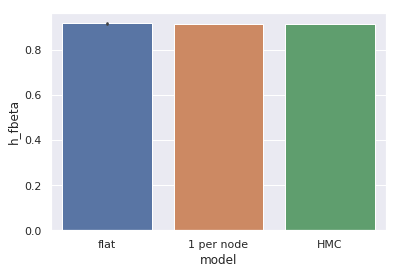

In [16]:
sns.barplot(data=all_results, y="h_fbeta", x="model")#, hue="Ruido %")

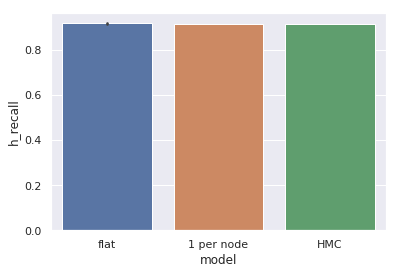

In [17]:
sns.barplot(data=all_results, y="h_recall", x="model")

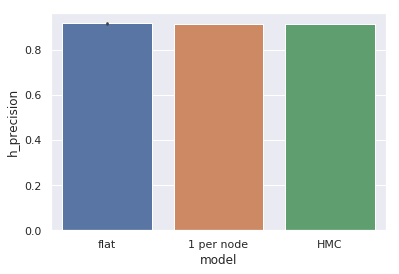

In [18]:
sns.barplot(data=all_results, y="h_precision", x="model")

In [19]:
for model in ["flat", "1 per node", "HMC"]:
    model_results = all_results.query("model == @model")
    print(f"For model {model}, we obtained ", 
          f"{model_results.h_fbeta.mean()} h_fbeta +-",
          f"{model_results.h_fbeta.std()}")

For model flat, we obtained  0.9174459333111844 h_fbeta +- 0.0034399856342651686
For model 1 per node, we obtained  0.9146324146151528 h_fbeta +- 0.004212353606119046
For model HMC, we obtained  0.9163660654642618 h_fbeta +- nan


In [20]:
all_results

,h_fbeta,h_precision,h_recall,model
0,0.909163,0.90778,0.910551,flat
1,0.92322,0.923281,0.923159,flat
2,0.921344,0.920064,0.922628,flat
3,0.916899,0.915685,0.918115,flat
4,0.917209,0.91843,0.915992,flat
5,0.921943,0.922188,0.921699,flat
6,0.91686,0.915344,0.918381,flat
7,0.909586,0.909948,0.909224,flat
8,0.914892,0.914589,0.915196,flat
9,0.912594,0.910665,0.914532,flat
